In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [4]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [5]:
from core.datasets.vqa_gen_dataset import VqaGenDataset , VQACollator, VqaDataset
from core.ofa.label_smoothed_cross_entropy import AdjustLabelSmoothedCrossEntropyCriterion
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig
from accelerate import Accelerator
from accelerate.utils import DistributedDataParallelKwargs
from accelerate import DistributedType

In [6]:
import transformers

## Convert pt to pretrained bin

In [8]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/base_vqa/ofa_vqa.14500.pt"


In [9]:
kwargs = DistributedDataParallelKwargs(find_unused_parameters = True)
accelerator = Accelerator(kwargs_handlers = [kwargs])

In [10]:
# fine_tuned ="/srv/scratch/sanisetty3/DLM/OFA_VQA/checkpoints/results/ofa_vqa.32000.pt"
pkg = torch.load(fine_tuned, map_location = 'cpu')

In [11]:
ofa_config = OFAConfig.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-base-vqa/')
vqa_model = OFAModelForVQA(ofa_config)

/srv/share2/sanisetty3/miniconda3/envs/ai-choreo/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
unwrapped_model = accelerator.unwrap_model(vqa_model)

In [13]:
unwrapped_model.load_state_dict(pkg['model'])

<All keys matched successfully>

In [14]:
unwrapped_model.save_pretrained('/coc/scratch/sanisetty3/DLM/ofa-base-vqa/', save_function=accelerator.save)

##  Weight transfer to transformer model

In [79]:
model_b = OFAModelForVQA.from_pretrained("OFA-base/", use_cache=False)


In [81]:
base = torch.load("OFA-base/pytorch_model.bin")

In [172]:
base_vqa = torch.load("vqa_base_best.pt")["model"]
del base_vqa["encoder.version"]
del base_vqa["decoder.version"]

In [173]:
def change_key(self, old, new):
    for _ in range(len(self)):
        k, v = self.popitem(False)
        self[new if old == k else k] = v

In [174]:
 my_dic_keys = list(base_vqa.keys())

In [175]:
for i in my_dic_keys:
#     print(i)
    if "ffn_layernorm" in i and "encoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
    if "attn_ln" in i and "encoder" in i:
        new = str(i).replace("attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new)
        print(i)
        
    if "encoder_attn" in i and "decoder" in i:
        new = str(i).replace("encoder_attn","cross_attn")
        change_key(base_vqa , i , new)
        
    if "ffn_layernorm" in i and "decoder" in i:
        new = str(i).replace("ffn_layernorm","ffn_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "cross_attn_ln" in i and "decoder" in i:
        new = str(i).replace("cross_attn_ln","cross_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 
        
    if "self_attn_ln" in i and "decoder" in i:
        new = str(i).replace("self_attn_ln","self_attn_mid_layer_norm")
        change_key(base_vqa , i , new) 

encoder.layers.0.attn_ln.weight
encoder.layers.0.attn_ln.bias
encoder.layers.0.ffn_layernorm.weight
encoder.layers.0.ffn_layernorm.bias
encoder.layers.1.attn_ln.weight
encoder.layers.1.attn_ln.bias
encoder.layers.1.ffn_layernorm.weight
encoder.layers.1.ffn_layernorm.bias
encoder.layers.2.attn_ln.weight
encoder.layers.2.attn_ln.bias
encoder.layers.2.ffn_layernorm.weight
encoder.layers.2.ffn_layernorm.bias
encoder.layers.3.attn_ln.weight
encoder.layers.3.attn_ln.bias
encoder.layers.3.ffn_layernorm.weight
encoder.layers.3.ffn_layernorm.bias
encoder.layers.4.attn_ln.weight
encoder.layers.4.attn_ln.bias
encoder.layers.4.ffn_layernorm.weight
encoder.layers.4.ffn_layernorm.bias
encoder.layers.5.attn_ln.weight
encoder.layers.5.attn_ln.bias
encoder.layers.5.ffn_layernorm.weight
encoder.layers.5.ffn_layernorm.bias


In [176]:
mis = []
for i in (base_vqa.keys()):
    
    if i in base.keys():
        continue
    else:
        print(i)
        mis.append(i)

len(mis)

0

In [177]:
torch.save(base_vqa , "OFA-base-vqa/pytorch_model.bin")

In [178]:
model_p = OFAModelForVQA.from_pretrained("OFA-base-vqa/", use_cache=False)


## Test VQAv2

In [7]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)


NameError: name 'pretrained' is not defined

In [ ]:
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)
model_f = OFAModelForVQA.from_pretrained('/coc/scratch/sanisetty3/DLM/OFA-tiny-fine-tune/', use_cache=False)

In [ ]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

In [155]:
ann_file = os.path.join('/srv/scratch/sanisetty3/DLM/AliceMind/mPLUG/data/json/vqa_ocr_object/' ,"vqa_train_ocr.json")
vqa_root = '/srv/datasets/coco/'


In [156]:
ds = VqaDataset(
    ann_file=[ann_file],
    vqa_root=vqa_root,
)
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [157]:
for batch in dl:
    break

In [158]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' what fruit is growing on the bush?', ' is the horse outside?', ' is the saddle western?', ' how many frisbees is the man holding?', ' what is his name?', ' where is the clock?', ' does the tennis player have an audience?', ' what are the men looking at online?']


In [159]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['oranges', 'yes', 'yes', '2', 'lin', 'table', 'no', 'work']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


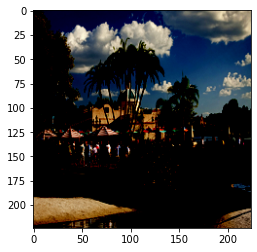

In [160]:
plt.imshow(batch["patch_images"][0].permute(1,2,0).cpu().numpy())

## Test Stack

In [8]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
finetuned = '/coc/scratch/sanisetty3/DLM/ofa-base-vqa/'

In [9]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)


/coc/scratch/sanisetty3/DLM/OFA-base-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
model_f = OFAModelForVQA.from_pretrained(finetuned, use_cache=False)


In [11]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [12]:
from core.datasets.vqa_gen_dataset import VQACollator, VqaDataset,VqaStackDataset,CLEVRVQADataset


In [13]:
ann_file = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/stack_train_questions.json"
vqa_root = "/srv/scratch/sanisetty3/DLM/sornet/data/block_stacking/Relational_dataset/images"

In [39]:
ds = VqaStackDataset(
    ann_file=ann_file,
    vqa_root=vqa_root,
)
stack_data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
stack_dl = DataLoader(ds, batch_size = 8, collate_fn=stack_data_collator ,num_workers = 0, shuffle = True)


/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [21]:
ds = CLEVRVQADataset(split="valA")
data_collator = VQACollator(tokenizer=tokenizer_p, max_seq_length=128)
dl = DataLoader(ds, batch_size = 8, collate_fn=data_collator ,num_workers = 0, shuffle = True)


In [15]:
for batch in dl:
    break

In [16]:
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True))

[' there is a brown cube; are there any red cubes in front of it?', ' there is a cyan thing; are there any cyan things behind it?', ' the object that is underneath the yellow thing is what color?', ' there is a purple thing; are there any red cubes above, it?', ' what is the color of the block that is below the red thing?', ' there is a thing behind the gray cube; what is its color?', ' there is a cube underneath the green thing; what is its color?', ' there is a green block; are there any cyan cubes to the right of it?']


In [17]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['False', 'False', 'gray', 'False', 'blue', 'brown', 'purple', 'False']


### Pretrained

In [20]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['False', 'False', 'gray', 'False', 'blue', 'brown', 'purple', 'False']


In [22]:
gen = model_p.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [23]:
tokenizer_p.batch_decode(gen, skip_special_tokens=True)

[' yes', ' yes', ' gray', ' yes', ' blue', ' blue', ' purple', ' yes']

In [30]:
indx = 2
img = batch["patch_images"][indx].permute(1,2,0).cpu().numpy()*[0.5, 0.5, 0.5]+ [0.5, 0.5, 0.5]

the object that is underneath the yellow thing is what color?
gray


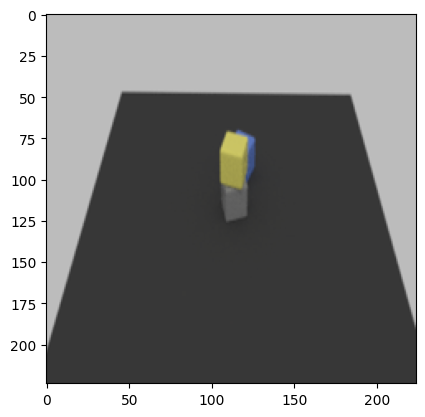

In [31]:
plt.imshow(img)
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print(tokenizer_p.batch_decode(gen, skip_special_tokens=True)[indx].strip())

### Finetuned

In [32]:
print(tokenizer_p.batch_decode(batch["target"], skip_special_tokens=True))

['False', 'False', 'gray', 'False', 'blue', 'brown', 'purple', 'False']


In [25]:
gen_fin = model_f.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)

In [46]:
np.vstack([gen_fin , gen_fin]).shape

(16, 3)

In [26]:
tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)

['no', 'no', 'gray', 'no', 'blue', 'green', 'blue', 'no']

there is a brown cube; are there any red cubes in front of it?
no


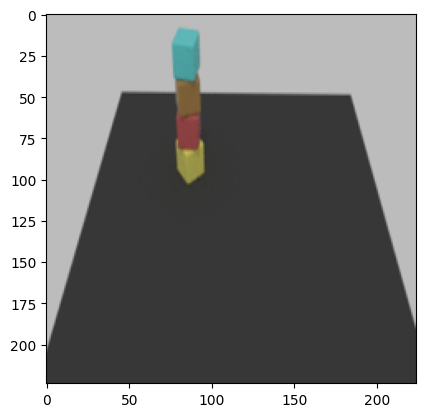

In [27]:
plt.imshow(img)
print(tokenizer_p.batch_decode(batch["input_ids"], skip_special_tokens=True)[indx].strip())
print(tokenizer_p.batch_decode(gen_fin, skip_special_tokens=True)[indx].strip())

## Eval script

In [35]:
from evaluate import evaluator

task_evaluator = evaluator("question-answering")


In [36]:
from datasets import load_metric

In [40]:
metric = load_metric('accuracy','f1')

In [48]:
from tqdm import tqdm
targets = None
pred = None
for batch in tqdm(stack_dl):
    try:
        targets = np.vstack([targets , batch["target"]])
    except: 
        targets = batch["target"]
        
    gen_fin = model_f.generate(batch["input_ids"], patch_images=batch["patch_images"], num_beams=5, no_repeat_ngram_size=3)
    
    try:
        pred = np.vstack([pred , gen_fin])
    except: 
        pred = gen_fin
        
    
    
    

  0%|                                                                  | 0/604 [00:00<?, ?it/s]/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  2%|▉                                                      | 10/604 [06:43<6:39:15, 40.33s/it]


KeyboardInterrupt: 

In [ ]:
final_score = metric.compute(predictions=pred, references=targets)

## Custom image and question

In [24]:
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-base-vqa/'
fine_tuned ="/srv/scratch/sanisetty3/DLM/ofa-vqa-tiny/"


In [25]:
tokenizer_p = OFATokenizer.from_pretrained(pretrained)
model_p = OFAModelForVQA.from_pretrained(pretrained, use_cache=False)

/coc/scratch/sanisetty3/DLM/OFA-huge-vqa/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [17]:
model_f = OFAModelForVQA.from_pretrained(fine_tuned, use_cache=False)

In [18]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


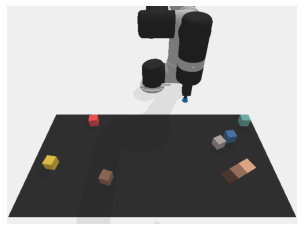

In [121]:
txt = "Is the yellow block on top of the red block?"
inputs = tokenizer_p([txt], return_tensors="pt").input_ids
img = Image.open('./samples/00.png')
patch_img = patch_resize_transform(img).unsqueeze(0)
img

### Pretrained

In [122]:
custom_gen = model_p.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

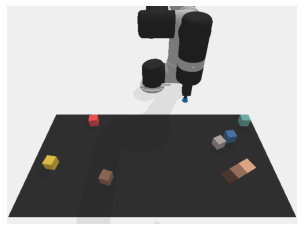

yellow block on top of red block no


In [123]:
display(img)
print(tokenizer_p.batch_decode(custom_gen, skip_special_tokens=True)[0].strip())

### Fine tuned

In [124]:
custom_gen_fin = model_f.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

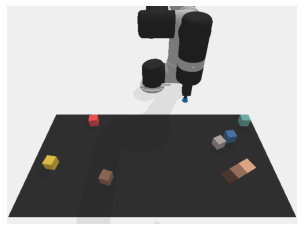

no


In [125]:
display(img)
print(tokenizer_p.batch_decode(custom_gen_fin, skip_special_tokens=True)[0].strip())

## Push to hub

In [1]:
from core.ofa import OFATokenizer
from core.ofa.modeling_ofa import OFAModelForVQA
from core.ofa.configuration_ofa import OFAConfig

In [5]:
fine_tuned ="/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/"
pretrained ='/coc/scratch/sanisetty3/DLM/OFA-tiny/'

tokenizer_p = OFATokenizer.from_pretrained(fine_tuned)


/coc/scratch/sanisetty3/DLM/OFA-tiny-vqa-finetune/
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [6]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
Token has not been saved to git credential helper.
Your token has been saved to /nethome/sanisetty3/.cache/huggingface/token
Login successful


In [8]:
!transformers-cli repo create OFA-tiny-vqa-finetune

WARNING! Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead.
git version 2.7.4
git-lfs/2.7.2 (GitHub; linux amd64; go 1.12.4)

Traceback (most recent call last):
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/bin/transformers-cli", line 8, in <module>
    sys.exit(main())
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/commands/transformers_cli.py", line 55, in main
    service.run()
  File "/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/transformers/commands/user.py", line 177, in run
    user, _ = whoami(token)
ValueError: too many values to unpack (expected 2)
